In [66]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import pickle
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error

In [46]:
categorical = ['PULocationID','DOLocationID']
numerical = ['trip_distance']
target = 'duration'
def get_df(parquet_file_path):
    df = pd.read_parquet(parquet_file_path)
    df = df[df.trip_type==1.0]
    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda x: x.total_seconds()/60)
    df = df[(df.duration >= 1) & (df.duration <=60)]
    df[categorical] = df[categorical].astype(str)
    df['PU_DO'] = df['PULocationID'] + '_' + df['DOLocationID']   # creating a new feature
    return df

In [47]:
train_df = get_df("data/green_tripdata_2025-01.parquet")
val_df = get_df("data/green_tripdata_2025-02.parquet")
val_df.trip_distance = val_df.trip_distance.apply(lambda x: val_df['trip_distance'].mean() if x>13 else x)

In [48]:
dv = DictVectorizer()
new_feature = ['PU_DO']
train_dict = train_df[new_feature + numerical].to_dict(orient='records')
val_dict = val_df[new_feature + numerical].to_dict(orient='records')

x_train = dv.fit_transform(train_dict)
y_train = train_df[target].values

x_val = dv.transform(val_dict)
y_val = val_df[target].values

In [40]:
lr = LinearRegression()
lr.fit(x_train,y_train);

In [62]:
rid = Ridge()
rid.fit(x_train,y_train);

In [63]:
y_pred = rid.predict(x_val)

In [64]:
mse = mean_squared_error(y_pred,y_val,squared=False)
mse

5.42504470359854

/home/codespace/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/codespace/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


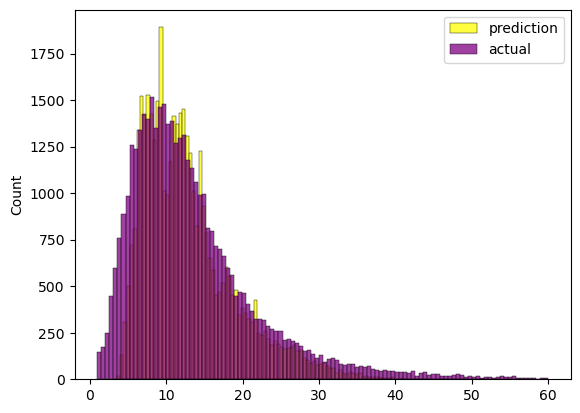

In [65]:
sns.histplot(y_pred,label='prediction',color='yellow')
sns.histplot(y_val,label='actual',color='purple')
plt.legend()

In [68]:
with open('models/rid_mod.bin','wb') as f_out:
    pickle.dump((dv,rid),f_out)